In [1]:
import sys
sys.path.append('../')

from fastai.text.all import *
from fastai.vision.all import *

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *
from mrl.torch_imports import *

from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.policy_gradient import PolicyGradient, TRPO, PPO
from mrl.environment import *
from mrl.reward import *

/home/dmai/miniconda3/envs/mrl_f/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(0)

In [3]:
vocab = CharacterVocab(AMINO_ACID_VOCAB)

ds = TextDataset(['M'], vocab)

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
lstm_drop = 0.
lin_drop = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

lm_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
                lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

loss = CrossEntropy()

lm_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_swissprot.pt'))

loss = CrossEntropy()

In [4]:
vh = ValueHead(256)

In [5]:
agent = GenerativeAgent(lm_model, vocab, loss, ds, value_head=vh, opt_kwargs={'lr':1e-4},
                       base_update=0.97, v_update=0.9, vopt_kwargs={'lr':1e-3})

In [6]:
df = pd.read_csv('../../smiles_datasets/swissprot_clean.csv')

In [7]:
df = df[df.sequence.map(lambda x: len(x)<=50)]

In [8]:
df.shape

(12272, 2)

In [9]:
agent.update_dataset_from_inputs(df.sequence.values)

In [10]:
# agent.train_supervised(64, 3, 1e-5)

In [11]:
template = Template([ValidityFilter()], [], fail_score=-1., log=False, mode='protein')

In [12]:
update_cb = UpdateBaselineCB(agent, 5, 'base_update')
stat_cb = StatsCallback('live', 'stat_cb', 10)
roll_cb = RetrainRollback(agent, 98, 0.5, 5e-5, 64, 'live_valid', 20, 0.5, 'rb')
reward_cb = LogSampler('rewards', 10, 95, buffer_size=10)
train_cb = SupevisedCB(agent, 200, 0.5, 98, 5e-5, 64)
novel_cb = NoveltyBonus(0.05, 'novel')

In [13]:
cbs = [update_cb, stat_cb, roll_cb, reward_cb, novel_cb, train_cb]

In [14]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        x = self.model(x)
        return torch.clamp(x, -15, 15)
#         return x.sigmoid()

In [15]:
df = pd.read_csv('../../smiles_datasets/amps/amp_clean.csv')

r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.4, 0.4, 0.4, 0.4])
r_model.load_state_dict(torch.load('../nbs/untracked_files/amp_class.pt'))
r_model.eval()
# r_model = ModelWrapper(r_model)

def ECFP6_pep(mol):
    mol = to_protein(mol)
    return ECFP6(mol)

r_ds = Vec_Prediction_Dataset(df.sequence.values, df.label.values, ECFP6_pep)

r_agent = PredictiveAgent(r_model, BinaryCrossEntropy(), r_ds, opt_kwargs={'lr':1e-3})

r_model.eval();

freeze(r_model)

# class RF():
#     def __init__(self, agent):
#         self.agent = agent
        
#     def __call__(self, inputs):
#         with torch.no_grad():
#             return self.agent.predict_data(inputs)

# amp_reward = SampleReward(RF(r_agent), True, 'amp', weight=1.)

amp_reward = SampleReward(r_agent.predict_data, True, 'amp', weight=1.)

In [16]:
gen_bs = 800
bs = 200

In [17]:
agent_cb = GenAgentCallback(agent, 'generative')

In [18]:
sampler1 = ModelSampler(agent, agent.model, 'live', 500, 0.6, gen_bs, latent=False)
sampler2 = ModelSampler(agent, agent.base_model, 'base', 500, 0., gen_bs)

samplers = [sampler1, sampler2]

In [19]:
# pg = PolicyGradient(ratio=True)
# pg = TRPO(0.97, 4.)
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
pg_loss = LossCallback(pg, 'pg')

In [20]:
template_cb = TemplateCallback(template)

In [21]:
env = Environment(agent_cb, template_cb, samplers=samplers, reward_cbs=[amp_reward], loss_cbs=[pg_loss],
                 cbs=cbs)

In [17]:
%%time
env.fit(bs, 150, 4, 2)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,amp,live_p90,live_max,novel
0,0.251,0.000,1.000,1.000,200,0.013,1.000,1.000,0.251,1.000,0.201,0.656,1.041,1.000
2,0.266,0.000,1.000,1.000,200,-0.017,1.000,1.000,0.314,1.000,0.216,0.856,1.049,1.000


CPU times: user 43.4 s, sys: 148 ms, total: 43.6 s
Wall time: 40.1 s


In [22]:
%%time
env.fit(bs, 100, 2000, 10)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,amp,live_p90,live_max,novel
0,-3.093,0.000,1.000,1.000,200,0.638,1.000,1.000,-3.027,1.000,-3.143,-1.308,4.296,0.050
10,-2.185,0.000,1.000,1.000,200,0.810,1.000,1.000,-1.995,1.000,-2.235,0.619,6.010,0.050
20,-2.468,0.000,1.000,1.000,200,0.804,1.000,1.000,-2.418,1.000,-2.518,0.828,5.584,0.050
30,-1.999,0.000,1.000,1.000,200,1.046,1.000,1.000,-1.744,1.000,-2.048,2.478,6.668,0.050
40,-2.031,0.000,1.000,1.000,200,0.949,1.000,1.000,-1.830,1.000,-2.081,1.772,6.370,0.050
50,-1.612,0.000,1.000,1.000,200,0.932,1.000,1.000,-1.455,1.000,-1.662,2.496,6.679,0.050
60,-1.918,0.000,1.000,1.000,200,0.743,1.000,1.000,-1.815,1.000,-1.968,1.994,5.849,0.050
70,-1.657,0.000,1.000,1.000,200,0.833,1.000,1.000,-1.555,1.000,-1.707,3.014,5.993,0.050
80,-1.780,0.000,1.000,1.000,200,0.686,1.000,1.000,-1.549,1.000,-1.830,2.415,5.943,0.050
90,-1.374,0.000,1.000,1.000,200,0.741,1.000,1.000,-1.092,1.000,-1.424,3.788,7.165,0.050


Epoch,Train Loss,Valid Loss,Time
0,2.75360,2.68127,00:00


Epoch,Train Loss,Valid Loss,Time
0,2.62013,2.49970,00:01


Epoch,Train Loss,Valid Loss,Time
0,2.41411,2.46454,00:01


Epoch,Train Loss,Valid Loss,Time
0,2.16805,2.21112,00:02


Epoch,Train Loss,Valid Loss,Time
0,1.94001,1.62478,00:02


Epoch,Train Loss,Valid Loss,Time
0,1.88209,1.96248,00:03


Epoch,Train Loss,Valid Loss,Time
0,1.86033,2.00075,00:03


Epoch,Train Loss,Valid Loss,Time
0,1.87425,1.88358,00:04


Epoch,Train Loss,Valid Loss,Time
0,1.79315,1.80440,00:05


Epoch,Train Loss,Valid Loss,Time
0,1.60891,1.67417,00:05


CPU times: user 4h 5min 31s, sys: 5.99 s, total: 4h 5min 37s
Wall time: 3h 33min 13s


In [33]:
%%time
env.fit(bs, 100, 500, 10)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,amp,live_p90,live_max,novel
2000,13.011,0.000,1.000,1.000,200,0.308,1.000,1.000,13.180,1.000,12.961,14.853,16.085,0.050
2010,12.831,0.000,1.000,1.000,200,0.267,1.000,1.000,13.079,1.000,12.781,14.673,15.932,0.050
2020,13.155,0.000,1.000,1.000,200,0.283,1.000,1.000,13.188,1.000,13.106,15.128,16.487,0.050
2030,13.240,0.000,1.000,1.000,200,0.240,1.000,1.000,13.220,1.000,13.190,15.107,15.945,0.050
2040,13.058,0.000,1.000,1.000,200,0.233,1.000,1.000,13.120,1.000,13.009,14.710,16.068,0.050
2050,13.517,0.000,1.000,1.000,200,0.259,1.000,1.000,13.719,1.000,13.467,15.271,16.597,0.050
2060,13.455,0.000,1.000,1.000,200,0.215,1.000,1.000,13.621,1.000,13.406,15.409,16.415,0.049
2070,13.416,0.000,1.000,1.000,200,0.241,1.000,1.000,13.636,1.000,13.366,15.345,16.444,0.050
2080,13.639,0.000,1.000,1.000,200,0.197,1.000,1.000,13.753,1.000,13.589,15.250,16.849,0.050
2090,13.534,0.000,1.000,1.000,200,0.198,1.000,1.000,13.550,1.000,13.484,15.020,16.330,0.050


Epoch,Train Loss,Valid Loss,Time
0,1.64053,1.66208,00:06


Epoch,Train Loss,Valid Loss,Time
0,1.57705,1.57122,00:06


CPU times: user 1h 6min 36s, sys: 1.67 s, total: 1h 6min 38s
Wall time: 57min 58s


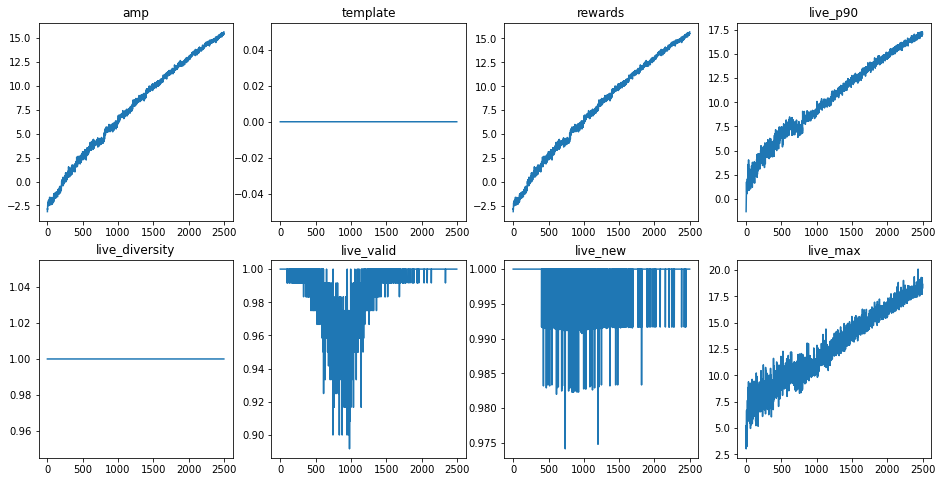

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))
plot_vals = ['amp', 'template', 'rewards', 'live_p90',
             'live_diversity', 'live_valid', 'live_new', 'live_max']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.metrics[plot_vals[i]]))
    ax.set_title(plot_vals[i])

In [36]:
log_df = log_to_df(env.log.log, ['samples', 'rewards', 'template', 'amp'])

In [37]:
log_df.drop_duplicates(subset='samples', inplace=True)

In [38]:
log_df.shape

(494151, 5)

In [41]:
log_df[log_df.rewards>19]

,batch,samples,rewards,template,amp
442861,2229,GLLHTIGKVIGGVVGTLAHGVVKVFGVVLGGWWGGIICCSFCKGGPTPIWPLPGHPIPIIPGTILPGGPIWPKPSPPGKGIPIPKPGGGPGPGGGPWPWP,19.002102,0,18.952103
473381,2382,GLWSIIGKILGGVIKAVVKIFGKWAGTVWGGGWPIGITTIGHGTWTCWPIKCRGKGGGNPIPFPIPTPKPLGTGGGGGHPLPGGGPKPPMPSPKPPPGPG,19.351091,0,19.301092
484274,2436,GLFGVIGKILGAVVSKAAGKCWGGVGGHPIPWPIWKFSTIKGVWPILCKGHGNPIPIGKGTIGGNPTPPPKPTPKGNPPGGPLPSPGPPGGGPGPGPGPG,20.073505,0,20.023506
486786,2449,GLWTVLKCIGKVLGGVIKGTWSTIKGFWGGVCFKHGNGNPIPIGTIIPKGKGTWPGPIPTPHTPSCRGGGNPGPFPSPIPIPSPPSPPPPGHPGGPKPPG,19.092468,0,19.042469
487034,2450,GLFGIIGNILPTILGVLAGKTVGKVVKKIIGIISWGGICKFSTWGNPTPIIKSSPKIISIVKGIGHGKGNPTPLPTPSPIPKPSPGGGGGGHPWPLPKGG,19.019464,0,18.969465
492479,2477,GLLGVLGKILGAVVKAIKKVFGVIWGTWGVCRWGGGGGPWPIPIFSLFKSVGNIAKGGKGIWPNIPICPTPLPRGHPIPIGNPGPGGNGGPKPSPGGPPG,19.006197,0,18.956198
493263,2481,GLWSKIGKVLGKVVGTVKGVVKKFFGTWGGWAWGIVVCCVFGHPIGGNPWPIWTHTSSFTISIGKGIPHPTPLPKPIGNPKPGGGPWPKPSPGPK,19.285442,0,19.235443
495975,2495,GLWSKLGKAIGGVLGGVVTKCFGKGWPIAIAKGVWPIWGNPIISPWKPISCRGGGPKPIPIPTPKPLPIGKPLGGGNGPGGKPGPKPSPWPPPPPPLPGP,19.264170,0,19.214170


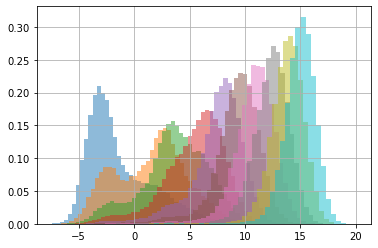

In [42]:
for chunk in chunk_list(log_df,50000):
    chunk.amp.hist(density=True, alpha=0.5, bins=50)

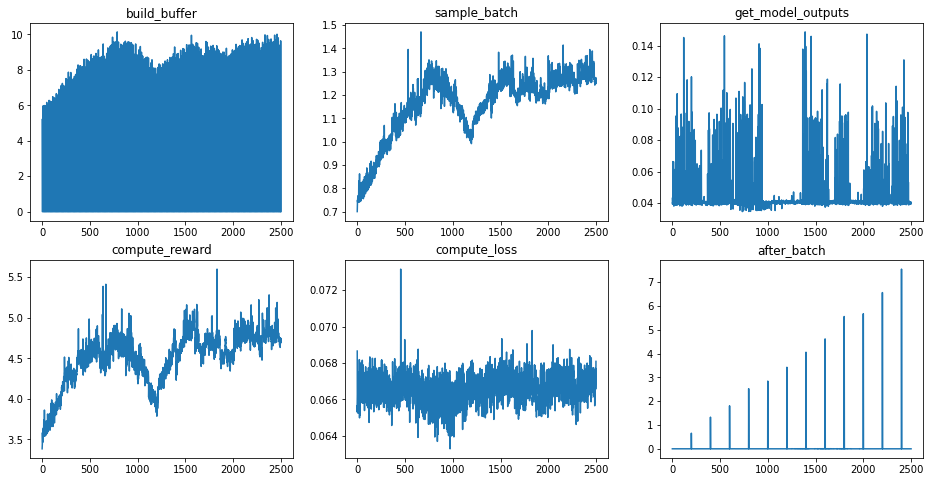

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))
plot_vals = ['build_buffer', 'sample_batch', 'get_model_outputs', 
             'compute_reward', 'compute_loss', 'after_batch']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.timelog[plot_vals[i]]))
    ax.set_title(plot_vals[i])

https://github.com/bcgsc/AMPlify

# Supervised setup

In [2]:
os.environ['ncpus'] = '16'
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../../smiles_datasets/swissprot_clean.csv', usecols=['sequence'])

In [4]:
df = df[df.sequence.map(lambda x: len(x)<=600)]

In [5]:
df.shape

(490712, 1)

In [6]:
vocab = CharacterVocab(AMINO_ACID_VOCAB)

In [7]:
# ds = TextDataset(df.sequence.values, vocab)

In [8]:
class SortishSampler(Sampler):
    """Returns an iterator that traverses the the data in randomly ordered batches that are approximately the same size.
    The max key size batch is always returned in the first call because of pytorch cuda memory allocation sequencing.
    Without that max key returned first multiple buffers may be allocated when the first created isn't large enough
    to hold the next in the sequence.
    """
    def __init__(self, data_source, key, bs):
        self.data_source,self.key,self.bs = data_source,key,bs

    def __len__(self): return len(self.data_source)

    def __iter__(self):
        idxs = np.random.permutation(len(self.data_source))
        sz = self.bs*50
        ck_idx = [idxs[i:i+sz] for i in range(0, len(idxs), sz)]
        sort_idx = np.concatenate([sorted(s, key=self.key, reverse=True) for s in ck_idx])
        sz = self.bs
        ck_idx = [sort_idx[i:i+sz] for i in range(0, len(sort_idx), sz)]
        max_ck = np.argmax([self.key(ck[0]) for ck in ck_idx])  # find the chunk with the largest key,
        ck_idx[0],ck_idx[max_ck] = ck_idx[max_ck],ck_idx[0]     # then make sure it goes first.
        sort_idx = np.concatenate(np.random.permutation(ck_idx[1:]))
        sort_idx = np.concatenate((ck_idx[0], sort_idx))
        return iter(sort_idx)

In [9]:
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
lstm_drop = 0.
lin_drop = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

lm_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
                lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

loss = CrossEntropy()

In [10]:
bs = 512

train_df = df.sample(frac=0.95, random_state=42)
valid_df = df[~(df.index.isin(train_df.index))]

In [11]:
train_ds = TextDataset(train_df.sequence.values, vocab)
valid_ds = TextDataset(valid_df.sequence.values, vocab)

sampler = SortishSampler(train_ds, lambda x: len(train_ds.smiles[x]), bs)

train_dl = train_ds.dataloader(bs, num_workers=16, sampler=sampler)
valid_dl = valid_ds.dataloader(bs, shuffle=False, num_workers=16)

dl = DataLoaders(train_dl, valid_dl)

In [12]:
learn = Learner(dl, lm_model, loss_func=CrossEntropyLossFlat())

In [13]:
learn = learn.to_fp16()

In [14]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,2.207462,1.353774,04:51
1,2.128816,1.331982,05:03
2,2.131075,1.317823,05:10
3,2.179391,1.296393,04:38
4,2.044026,1.240583,04:33
5,1.962698,1.181512,04:52
6,1.894807,1.143738,04:58
7,1.767156,1.119020,04:36
8,1.834059,1.106992,05:02
9,1.848206,1.104928,04:53


/home/dmai/miniconda3/envs/mrl_f/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [15]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/lstm_lm_swissprot.pt')

In [3]:
amp_df = pd.read_csv('../../smiles_datasets/amps/amp_clean.csv')

In [4]:
amp_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.4, 0.4, 0.4, 0.4])

In [5]:
def ECFP6_pep(mol):
    mol = to_protein(mol)
    return ECFP6(mol)

In [6]:
train_df = amp_df[amp_df.dataset=='train']
valid_df = amp_df[amp_df.dataset=='valid']

In [18]:
amp_ds = Vec_Prediction_Dataset(train_df.sequence.values, train_df.label.values, ECFP6_pep)
test_ds = Vec_Prediction_Dataset(valid_df.sequence.values, valid_df.label.values, ECFP6_pep)

In [8]:
agent = PredictiveAgent(amp_model, BinaryCrossEntropy(), amp_ds, opt_kwargs={'lr':1e-3})

In [9]:
agent.train_supervised(64, 5, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,0.52397,0.35940,00:04
1,0.69090,0.25131,00:03
2,0.15589,0.20292,00:03
3,0.96684,0.25516,00:03
4,0.16780,0.08678,00:03


In [42]:
to_device(agent.model)
agent.model.train();

In [43]:
agent.train_supervised(64, 5, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.19369,0.11627,00:03
1,0.05261,0.08778,00:03
2,0.28911,0.07832,00:03
3,0.13068,0.09290,00:03
4,0.01676,0.11254,00:03


In [44]:
agent.model.eval();

In [45]:
test_dl = test_ds.dataloader(256, shuffle=False)

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(test_dl):
        x,y = batch
        x = to_device(x)
        p = agent.predict_tensor(x)
        preds.append(p.detach().cpu())
        targs.append(y.cpu())

In [46]:
preds = torch.cat(preds)
targs = torch.cat(targs)

In [47]:
preds.sigmoid()

tensor([[0.9499],
        [0.0184],
        [0.9986],
        ...,
        [0.0755],
        [0.0953],
        [0.0795]])

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [48]:
fpr, tpr, _ = roc_curve(targs.numpy(), preds.sigmoid().squeeze().numpy())

In [49]:
roc_auc = auc(fpr, tpr)

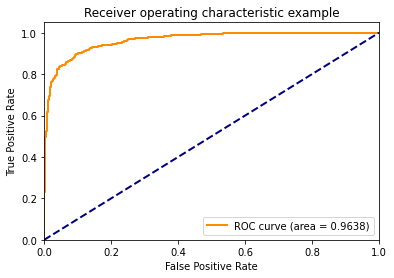

In [50]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [51]:
agent.model.cpu();

In [52]:
torch.save(agent.model.state_dict(), '../nbs/untracked_files/amp_class.pt')